# Imports

In [ ]:
!pip install pytorch-transformers transformers

In [ ]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, XLNetTokenizerFast
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Load Data & Model & Tokenizer

In [ ]:
# load pretrained model
model = XLNetForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/configs/XLnet_w_22000.h5")

In [ ]:
# Load training data
!wget https://msmarco.blob.core.windows.net/msmarcoranking/triples.train.small.tar.gz
!tar -xf triples.train.small.tar.gz

--2021-05-29 20:07:15--  https://msmarco.blob.core.windows.net/msmarcoranking/triples.train.small.tar.gz
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 20.150.34.4
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|20.150.34.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7930881353 (7.4G) [application/x-gzip]
Saving to: ‘triples.train.small.tar.gz.1’

triples.train.small 100%[===================>]   7.39G  5.55MB/s    in 29m 51s 

2021-05-29 20:37:07 (4.22 MB/s) - ‘triples.train.small.tar.gz.1’ saved [7930881353/7930881353]

^C


In [ ]:
tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_pos = pd.read_csv("/content/triples.train.small.tsv",
                    sep = "\t", nrows = 20000, header = None, skiprows = 11001, usecols = [0,1])  
train_neg = pd.read_csv("/content/triples.train.small.tsv",
                    sep = "\t", nrows = 20000, header = None, skiprows = 11001, usecols = [0,2]) 

train_pos.columns = ["query", "passage"]
train_neg.columns = ["query", "passage"]
train_pos["relevant"] = 1 # target label
train_neg["relevant"] = 0 

train = pd.concat([train_pos, train_neg])
train_neg = None
train_pos = None
train.reset_index(inplace=True, drop=True)           # Resetting Index as Concat makes duplicated sets 00 11 22 33 44 
train

,query,passage,relevant
0,how to describe mood and affect,"In psychology, affect is used to describe mood...",1
1,what is the md/mph program?,The MD/MPH program is designed to be completed...,1
2,kohl's edwardsville phone number,"Kohl's - Edwardsville 2120 Troy Rd, Edwardsvil...",1
3,another name for levaquin,"Levofloxacin (Levaquin) 1 In Europe, levoflox...",1
4,what part of chicago is the arie crown theater...,Location and Directions. ARIE CROWN THEATER. W...,1
...,...,...,...
39995,what does matthew 6:19-21 mean,Flights Fare Calendar Find minimum fare betwee...,0
39996,who was the white house counsel for president ...,Oliver Babish is the fifth White House Counsel...,0
39997,symptoms of laxative overdose,"Well, there are VERY few side effects of vitam...",0
39998,landstar fleet,"Alophen, Apo-bisacodyl (CA), Biolax (UK), Bisa...",0


In [ ]:
def load_data(pandas_dataframe):
  global tokenizer
  data_df = pandas_dataframe
  data_df["query"] = data_df["query"].astype(str)     # String
  data_df["passage"] = data_df["passage"].astype(str)
  queries = data_df["query"].to_list()
  passages = data_df["passage"].to_list()
  labels = data_df["relevant"].to_list()
  queries = [query + " [SEP] " for query in queries]
  passages = [passage + " [SEP] [CLS]" for passage in passages]
  return queries, passages, labels  

# Create Input from Data

In [ ]:
path = "gdrive/My Drive/Colab Notebooks/XLnet"
MAX_LEN = 200
train_x_queries, train_x_passages, labels = load_data(train)
train = None
tokenized_queries = [tokenizer.tokenize(row) for row in train_x_queries]
tokenized_passages = [tokenizer.tokenize(row) for row in train_x_passages]
input_ids_query = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_queries]
input_ids_passage = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_passages]
# Create attention masks
segment_masks = []
tokenized_texts = []
for tokenized_query, tokenized_passage in zip(input_ids_query, input_ids_passage):
  if MAX_LEN > len(tokenized_queries + tokenized_passages):
    segment_masks.append(tokenizer.create_token_type_ids_from_sequences(tokenized_query,tokenized_passage ))
  else:
    segment_masks.append(tokenizer.create_token_type_ids_from_sequences(tokenized_query,tokenized_passage[:200-len(tokenized_query)]))
  tokenized_texts.append(tokenized_query+ tokenized_passage)
tokenized_queries = None
tokenized_passage = None
input_ids = [q + p for q, p in zip(input_ids_query, input_ids_passage)]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
train_seg_masks, validation_seg_masks, _, _ = train_test_split(segment_masks, input_ids,random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
train_seg_masks = torch.tensor(train_seg_masks)
validation_seg_masks = torch.tensor(validation_seg_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. 
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs,train_seg_masks, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_seg_masks, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
#model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=1e-6)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Fine-tuning

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_seg_mask, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=b_seg_mask, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_seg_mask, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=b_seg_mask, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.44210500755906107


Epoch:  50%|█████     | 1/2 [35:20<35:20, 2120.92s/it]

Validation Accuracy: 0.8389471057884235
Train loss: 0.3705395465940237


Epoch: 100%|██████████| 2/2 [1:10:42<00:00, 2121.22s/it]

Validation Accuracy: 0.8484281437125752


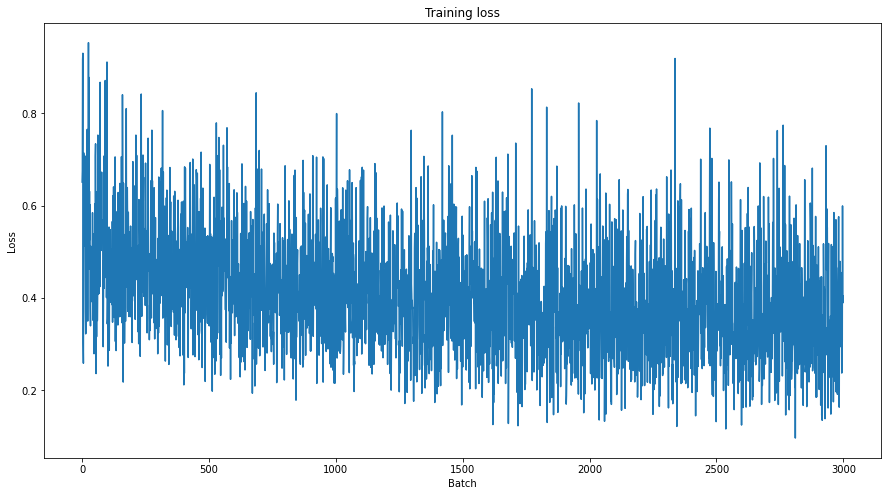

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Save model

In [ ]:
model.save_pretrained("/content/XLnet_62000.h5")

In [ ]:
from google.colab import files
files.download("/content/XLnet_62000.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>